In [1]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam
#
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
print("import done")

Using TensorFlow backend.


import done


In [2]:
#https://github.com/debadridtt/A-Review-of-Different-Word-Embeddings-for-Sentiment-Classification-using-Deep-Learning/blob/master/LSTM%20Experiment.ipynb

### Loading the data

In [3]:
import os
DATA_FILE = os.path.abspath('Data/DATA_preprocessing_version2.csv')
df = pd.read_csv(DATA_FILE,delimiter=',',encoding='UTF-8')
print(df.head())

   Unnamed: 0                                               text     label
0           0  have order data cable get well finish work pro...  NOTISSUE
1           1                                         love phone  NOTISSUE
2           2                            get well finish product  NOTISSUE
3           3                                     not be happier  NOTISSUE
4           4                 be look headset long time have get  NOTISSUE


In [4]:
df['label'].value_counts() #balanced Dataset


NOTISSUE    2028
ISSUE       2027
Name: label, dtype: int64

In [5]:
df.shape

(4055, 3)

### Exploratory Data Analysis

C:\Users\khmar\ana\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\khmar\ana\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


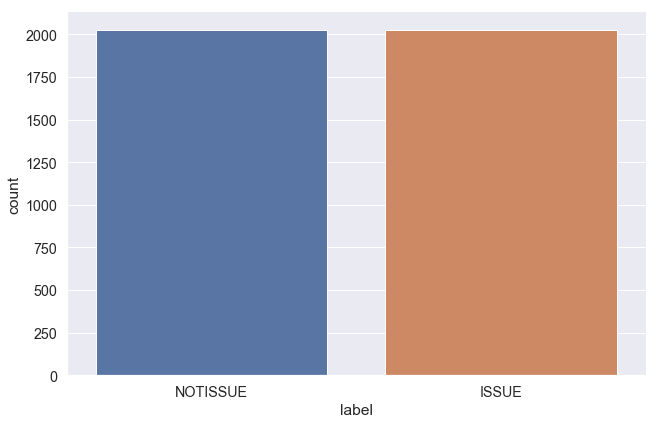

In [6]:
#Target variable
sns.factorplot(x="label", data=df, kind="count", size=6, aspect=1.5)
plt.show();

In [7]:
msk = np.random.rand(len(df)) < 0.7 # Splitting into train(70%) and test(30%) randomly

In [8]:
train_df=df[msk]
test_df=df[~msk]

In [9]:
print(train_df.shape)
print(test_df.shape)

(2836, 3)
(1219, 3)


In [10]:
print('Checking target values for train data:\n')
print(train_df['label'].value_counts(),'\n')
print('Checking target values for test data:\n')
print(test_df['label'].value_counts())

Checking target values for train data:

NOTISSUE    1433
ISSUE       1403
Name: label, dtype: int64 

Checking target values for test data:

ISSUE       624
NOTISSUE    595
Name: label, dtype: int64


In [11]:
train_df['label'].value_counts()


NOTISSUE    1433
ISSUE       1403
Name: label, dtype: int64

In [12]:
x_train=train_df['text']
y_train=train_df['label']
x_test=test_df['text']
y_test=test_df['label']

### GLOVE EMBEDDING 300

In [13]:
MAX_NB_WORDS = 20000
MAX_SEQUENCE_LENGTH = 200
maxlen = 120  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

In [14]:
texts_train = x_train.astype(str)
texts_test = x_test.astype(str)

In [15]:
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(texts_train)
sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

C:\Users\khmar\ana\lib\site-packages\keras_preprocessing\text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [16]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")
test_data = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH, padding="pre",
                          truncating="post")

In [17]:
print('Shape of data tensor:', data.shape)
print('Shape of test_data tensor:', test_data.shape)

Shape of data tensor: (2836, 200)
Shape of test_data tensor: (1219, 200)


In [18]:
import pickle
file_tok = 'LSTM_token_glove_300d_DATA_wit_text_processing7.sav'
pickle.dump(tokenizer, open(file_tok, 'wb'))

In [19]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 3060 unique tokens.


In [20]:
#pad sequences are used to bring all sentences to same size.
# pad sequences with 0s
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)
print('Shape of data test tensor:', x_test.shape)

Shape of data tensor: (2836, 200)
Shape of data test tensor: (1219, 200)


In [21]:
y_train = y_train.map({"NOTISSUE": 1, "ISSUE" : 0 })
y_test = y_test.map({"NOTISSUE": 1, "ISSUE" : 0 })

In [22]:
# load the whole embedding into memory
embeddings_index = {}
f = open('C:/Users/khmar/Desktop/GLOVE/glove.6B.300d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [23]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
#Found 1489 unique tokens : word_index
#print(len(word_index) + 1) #### 1490 
#print(word_index.items()) ### unique tokens : words :word_index
#print('embedding_matrix',embedding_matrix)
out_of_vocab={}
for word, i in word_index.items():
    #print(i)
    embedding_vector = embeddings_index.get(word)
    #print('embedding_vector' ,embedding_vector )
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        #print('word: ', word)
        embedding_matrix[i] = embedding_vector
        #print('embedding_matrix :',embedding_matrix[i] )
        # words not found in embedding index will be all-zeros.
    if embedding_vector is  None:
        print('word not found :',word)
        out_of_vocab[i] = word
            

word not found : flavourful
word not found : cosiness
word not found : shawarrma
word not found : beensteppedinandtrackedeverywhere
word not found : profiterole
word not found : cheesecurds
word not found : smashburger
word not found : comparablypriced
word not found : thereplacement
word not found : accessoryone
word not found : longwearing
word not found : wellie
word not found : barset
word not found : plantronincs
word not found : windresistant
word not found : flipphones
word not found : tracfonewebsite
word not found : antiglare
word not found : reoccure
word not found : chargelife
word not found : autoanswer
word not found : emailinc
word not found : merriamwebster
word not found : techsupport
word not found : convertor
word not found : thatsucked
word not found : convolute
word not found : zombiestudents
word not found : timewaster
word not found : directtovideo
word not found : youds
word not found : headoverheels
word not found : noncliche
word not found : worldweariness
word

In [24]:
f'There are {len(out_of_vocab)} out of vocab '

'There are 54 out of vocab '

In [25]:

model_glove= Sequential()
model_glove.add(Embedding(len(word_index) + 1,
                            300,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False))
model_glove.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2,input_shape=(1,)))
model_glove.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [26]:
model_glove.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [27]:
model_glove.fit(data, y_train,
          batch_size=batch_size,
          epochs=2,
          validation_data=(test_data, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 2836 samples, validate on 1219 samples
Epoch 1/2
2836/2836 [==============================] - 28s 10ms/step - loss: 0.5175 - acc: 0.7507 - val_loss: 0.4976 - val_acc: 0.7662
Epoch 2/2
2836/2836 [==============================] - 23s 8ms/step - loss: 0.3972 - acc: 0.8283 - val_loss: 0.4299 - val_acc: 0.8121


In [28]:
scores = model_glove.evaluate(x_test, y_test,
                            batch_size=batch_size)
print("%s: %.2f%%" % (model_glove.metrics_names[0], scores[0] * 100))
print("%s: %.2f%%" % (model_glove.metrics_names[1], scores[1] * 100))

1219/1219 [==============================] - 2s 2ms/step
loss: 42.99%
acc: 81.21%


In [29]:
# Save the model
model_glove.save('Model/LSTM_model_glove_300_DATA_with_text_processing_version2.sav')

### Prediction

In [30]:
##one text prediction!

In [31]:
def prediction(input_file,output_file):
    df= pd.DataFrame(columns=['label', 'text'])
    data = pd.read_csv(input_file,delimiter=',')
    inputt=data.text
    x_input = inputt.values
    ind=0
    for i in x_input:
        ind=ind+1
        text=np.array([i])
        seq= tokenizer.texts_to_sequences(text)
        sequences_matrix = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
        proba = model_glove.predict(sequences_matrix)
        class_pred = model_glove.predict_classes(sequences_matrix)
        classe=prediction_classe(class_pred)
        print(ind,i,proba,classe)
        df=df.append({'label':classe, 'text':i},ignore_index=True)
    df.to_csv(output_file,sep=';')
    return data,df

def prediction_classe(class_pred):
    if class_pred==0 :
        classe='ISSUE' 
    if class_pred==1 :
        classe='NOTISSUE'

    return classe

In [32]:
text="great product"
text=transformText(text)
text=np.array([text])
sequences= tokenizer.texts_to_sequences(text)
sequences_matrix = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
proba = model_glove.predict(sequences_matrix)
print(proba)
class_pred = model_glove.predict_classes(sequences_matrix)
print(prediction_classe(class_pred))

NameError: name 'transformText' is not defined

In [43]:
text="I have a problem can you help me"
text=transformText(text)
text=np.array([text])
sequences= tokenizer.texts_to_sequences(text)
sequences_matrix = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
proba = model_glove.predict(sequences_matrix)
print(proba)
class_pred = model_glove.predict_classes(sequences_matrix)
print(prediction_classe(class_pred))

[[0.29349816]]
ISSUE


In [44]:
text=" very recommend"
text=transformText(text)
print(text)
text=np.array([text])
sequences= tokenizer.texts_to_sequences(text)
sequences_matrix = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
proba = model_glove.predict(sequences_matrix)
print(proba)
class_pred = model_glove.predict_classes(sequences_matrix)
print(prediction_classe(class_pred))

recommend
[[0.6639067]]
NOTISSUE


In [45]:
#predict all data

In [33]:
input_file ='Data/DATA_preprocessing_version2.csv'
output_file ='Model/LSTM_data_pred_glove_300_with_text_version2.csv'
prediction(input_file,output_file)

1 have order data cable get well finish work product [[0.70032597]] NOTISSUE
2 love phone [[0.89979166]] NOTISSUE
3 get well finish product [[0.75248444]] NOTISSUE
4 not be happier [[0.34334463]] ISSUE
5 be look headset long time have get [[0.34004098]] ISSUE
6 headset start ring no reason [[0.07468732]] ISSUE
7 display be excellent camera be good year [[0.99523205]] NOTISSUE
8 battery life be great [[0.97289026]] NOTISSUE
9 worst phone have have have month [[0.12234124]] ISSUE
10 not good item work start have problem auto reverse tape player [[0.13083945]] ISSUE
11 be embarrass ear hurt try push ear plug ear [[0.08179733]] ISSUE
12 protect phone side [[0.60493875]] NOTISSUE
13 be average phone bad battery life operate weak network [[0.0337278]] ISSUE
14 clear skye call long battery life long range [[0.8107075]] NOTISSUE
15 solo technology suck [[0.4899065]] ISSUE
16 great hand free device [[0.9696232]] NOTISSUE
17 take self portrait outside exterior display cool [[0.7733446]] NOTISSUE

139 not recommend item anyone [[0.16641918]] ISSUE
140 holster arrive not match photo ad [[0.16713095]] ISSUE
141 great no problem all [[0.4428989]] ISSUE
142 earlier review note plug charger nothing happen [[0.17233604]] ISSUE
143 frog phone charm be adorable eye catch [[0.8045727]] NOTISSUE
144 never know push hard right number time function want not [[0.13834357]] ISSUE
145 sound be clear people talk amaze quality too [[0.424201]] ISSUE
146 get aluminum case new palm work wellie have protect handheld perfectly far [[0.93609005]] NOTISSUE
147 good product well make [[0.96201]] NOTISSUE
148 mobile phone tool have [[0.6502191]] NOTISSUE
149 be impress job motorola steadiness phone [[0.557565]] NOTISSUE
150 receive order well ship timeframe everything be good work order overall be excite have source [[0.86208797]] NOTISSUE
151 phone be sturdy waterproof [[0.63643104]] NOTISSUE
152 be not impress not recommend item anyone [[0.07131392]] ISSUE
153 complaint be standard sound volume be lit

272 post more detail comment grey black phone have fire red be great color [[0.8416137]] NOTISSUE
273 not have problem item order again need [[0.16744167]] ISSUE
274 get pay guess [[0.24933153]] ISSUE
275 not software do great job this make intone form exist cd internet connection [[0.614761]] NOTISSUE
276 be surprise be good quality car charger be not review it [[0.7471507]] NOTISSUE
277 fabulous [[0.9009214]] NOTISSUE
278 however bt headset currently not good real time game like first-person shooter audio delay mess up [[0.04108089]] ISSUE
279 price cable be excellent [[0.952003]] NOTISSUE
280 disappoint accessory good manufacturer [[0.4595646]] ISSUE
281 perform awful muffle tinny incoming sound severe echo end call [[0.03406996]] ISSUE
282 windresistant [[0.49692872]] ISSUE
283 obviously have terrible customer service get pay for [[0.10905913]] ISSUE
284 do not forever [[0.07673394]] ISSUE
285 it not overly expensive replace [[0.06043299]] ISSUE
286 easy operate sound be better hav

399 be convenient simple use get job make car ride smoother [[0.8382953]] NOTISSUE
400 nano state it my son be disappoint [[0.18986861]] ISSUE
401 sound quality be excellent well [[0.992812]] NOTISSUE
402 best headset have use [[0.7547486]] NOTISSUE
403 not recommend [[0.33079216]] ISSUE
404 have be year carry highest quality antiglare screen protector have find date [[0.81147295]] NOTISSUE
405 want [[0.53266525]] NOTISSUE
406 particular model not work motorola smartphone [[0.53458655]] NOTISSUE
407 not work right at least me [[0.30825356]] ISSUE
408 addition feel camp look phone be lightweight cheap plastic [[0.5321454]] NOTISSUE
409 be out warranty problem reoccure bottom line money else singular not support it [[0.062346]] ISSUE
410 want plantronics five ten be right one have issue me the good [[0.7459202]] NOTISSUE
411 crisp clear [[0.75223917]] NOTISSUE
412 charge keep go dead minute [[0.13365217]] ISSUE
413 cheap plastic creak like old wooden floor [[0.17624971]] ISSUE
414 get ab

538 be utterly confuse first cause lose couple very important contact [[0.11889309]] ISSUE
539 terrible phone holder [[0.14517944]] ISSUE
540 cutout button place perfectly [[0.92732555]] NOTISSUE
541 love be able use one headset landmine cell [[0.64177155]] NOTISSUE
542 problem be ear loop make weak material break easily [[0.04257862]] ISSUE
543 not nearly good look amazon picture make look [[0.54998827]] NOTISSUE
544 despite flaw case be exceptional quality well worth additional cost own official oem product [[0.3464134]] ISSUE
545 stupid be that [[0.07086232]] ISSUE
546 hear be drive car usually do not have be loudest set [[0.18751578]] ISSUE
547 seller ship quickly cheaper competitor [[0.5663959]] NOTISSUE
548 good show samsung [[0.9467537]] NOTISSUE
549 buy ten save lot money [[0.39088956]] ISSUE
550 cut make beep beep beep sound say signal fail [[0.02880455]] ISSUE
551 not figure [[0.2513746]] ISSUE
552 phone sound ok not great ok wife phone be totally unintelligible not understan

688 call again wait approximately thirty minute get customer help [[0.129438]] ISSUE
689 have not receive personal computer version [[0.27970588]] ISSUE
690 call center service be worst customer service have deal [[0.12211769]] ISSUE
691 have deal bad customer service [[0.09301118]] ISSUE
692 six extremely frustrate hour [[0.29728422]] ISSUE
693 do not have problem software [[0.0997925]] ISSUE
694 reverse error be nightmare [[0.02476181]] ISSUE
695 pretty do need [[0.5436392]] NOTISSUE
696 point customer service rep nice [[0.80975074]] NOTISSUE
697 do not have infrastructure provide basic level service [[0.21022668]] ISSUE
698 customer support system payroll upgrade product be scary [[0.2624352]] ISSUE
699 do not send receipt [[0.05438883]] ISSUE
700 receipt get be copy invoice be not format print correctly [[0.12382355]] ISSUE
701 be disturb be people suppose be account expert [[0.22467566]] ISSUE
702 start look alternative intuit obviously do not understand basic account audit princi

830 not provide support installation [[0.23731157]] ISSUE
831 software update be source issue [[0.29276875]] ISSUE
832 easy language sixteen be useful [[0.68622553]] NOTISSUE
833 find be helpful be get rusty [[0.3510763]] ISSUE
834 problem be be hard make [[0.14706108]] ISSUE
835 sound be not clear [[0.1932662]] ISSUE
836 record speaker do not bother slow give chance understand repeat be be say [[0.03964371]] ISSUE
837 be like listen actual french speaker [[0.41731346]] ISSUE
838 bad actually want learn pronounce be be say [[0.07178998]] ISSUE
839 be totally useless do not know basic french grammar [[0.04621469]] ISSUE
840 try use product learn become nightmare [[0.11108218]] ISSUE
841 do have version word phrase make easier sound out [[0.13950948]] ISSUE
842 unfortunately basic japanese grammar japanese alphabet write japanese [[0.05416694]] ISSUE
843 click have sound you [[0.78817487]] NOTISSUE
844 have no clue sound out [[0.1850186]] ISSUE
845 click sound [[0.77835196]] NOTISSUE
846

986 destroy system have format drive [[0.1455165]] ISSUE
987 warn [[0.20140603]] ISSUE
988 everything be great [[0.94849837]] NOTISSUE
989 have no problem fireball [[0.18980612]] ISSUE
990 have no problem [[0.1711707]] ISSUE
991 staff answer question [[0.4898197]] ISSUE
992 be excite get game [[0.5748049]] NOTISSUE
993 read previously write review [[0.41651505]] ISSUE
994 love spend time computer [[0.7368343]] NOTISSUE
995 game have fault [[0.1263974]] ISSUE
996 have listen review [[0.6143219]] NOTISSUE
997 game be enjoyable [[0.8790239]] NOTISSUE
998 make play hard frustrate [[0.19740745]] ISSUE
999 game be extremely clichy [[0.37117785]] ISSUE
1000 idea be great [[0.9318757]] NOTISSUE
1001 ugly [[0.10146331]] ISSUE
1002 new notebook not send/receive mail [[0.23236156]] ISSUE
1003 wireless connection not work [[0.30394828]] ISSUE
1004 not recommend product [[0.32508922]] ISSUE
1005 very very slow-moving aimless movie distress drift young man [[0.09551846]] ISSUE
1006 not sure be more 

1116 ironically find film total waste time watch [[0.13723345]] ISSUE
1117 be pander audience sabotage film [[0.05613131]] ISSUE
1118 story lack certain energy [[0.14198034]] ISSUE
1119 plot simply rumble like machine desperately depend addition new scene [[0.12814274]] ISSUE
1120 usual hitchcock logic flaw [[0.10557022]] ISSUE
1121 be extremely uninteresting [[0.20654474]] ISSUE
1122 be chilly unremarkable movie author living/working chilly abstruse culture [[0.61725324]] NOTISSUE
1123 flat re-enactments do not hold attention emotionally adrift stage [[0.06802284]] ISSUE
1124 rest sit be awful soldier sing song masculinity pledge to hairsplitting purity admiration sword etc [[0.5821593]] NOTISSUE
1125 bore piece kill momentum movie quicker else [[0.10219435]] ISSUE
1126 schroder have make resume lousy amateurish film [[0.02660657]] ISSUE
1127 however recently watch thing again do be completely strike extremely stupid storyline be contain hole inconsistency frankly lot crap horrid danc

1231 have have iq particularly stupid mollusc not see one come [[0.09301604]] ISSUE
1232 film be insult moviegoing public [[0.08999186]] ISSUE
1233 involve know string narrative [[0.4219653]] ISSUE
1234 get one simply be nothing lower [[0.08926674]] ISSUE
1235 be disappoint [[0.1775863]] ISSUE
1236 know be contract player little control script act be bad script [[0.02521866]] ISSUE
1237 victor mclaren be bad brian donlevy be unrecognizable [[0.06435999]] ISSUE
1238 consider relation screen taylor stanwyck be surprise little chemistry be screen two them [[0.56991994]] NOTISSUE
1239 premise film be ridiculous president [[0.19144255]] ISSUE
1240 death row scene entirely unmoving [[0.15054044]] ISSUE
1241 thing worse taylor act be stanwyck sing [[0.38573188]] ISSUE
1242 producer be go for miss entirely [[0.321386]] ISSUE
1243 cheap cheerless heist movie poor characterisation lot undermine style stoic demote [[0.0371661]] ISSUE
1244 squib look awful [[0.15205815]] ISSUE
1245 no point procee

1345 be not good [[0.4592597]] ISSUE
1346 speak music be unbearably predictably itchy [[0.07189671]] ISSUE
1347 film drop ball [[0.32877582]] ISSUE
1348 continuity error [[0.11404251]] ISSUE
1349 see movie be inspiration come overcome fear rejection [[0.05869858]] ISSUE
1350 be bad be actually worth see reason [[0.04680847]] ISSUE
1351 well keep think bad be [[0.21880656]] ISSUE
1352 be mediocre hollow laughable predictable piece garbage [[0.01823743]] ISSUE
1353 be case so bad be laughable [[0.01721186]] ISSUE
1354 bad performance play angela bennett computer expert be home time [[0.24454342]] ISSUE
1355 be film nothing pretext show ridiculous action scene [[0.02897098]] ISSUE
1356 awful be [[0.16106392]] ISSUE
1357 be bad actress repeat robotic face move picture [[0.12027467]] ISSUE
1358 result well shame [[0.13062514]] ISSUE
1359 delete film mind [[0.3121821]] ISSUE
1360 one worst show time [[0.09292484]] ISSUE
1361 show begin smart as ed comment be totally wall uncalled for [[0.075

1467 movie seem little slow first [[0.07227089]] ISSUE
1468 act film be glad go drift away earth far possible [[0.08130448]] ISSUE
1469 have not choke vomit end by cheap drama worthless dialogue have have bore death waste time [[0.03021795]] ISSUE
1470 instead get bore fest whiny spoil brat babysitting [[0.03508535]] ISSUE
1471 never walk movie faster [[0.2705879]] ISSUE
1472 unfortunately virtue film production work be lose regrettable script [[0.07733782]] ISSUE
1473 word be embarrass [[0.08948943]] ISSUE
1474 exceptionally bad [[0.04815006]] ISSUE
1475 insult one intelligence huge waste money [[0.03333184]] ISSUE
1476 be sad movie [[0.18795243]] ISSUE
1477 best scene movie be gerardo be try find song keep run head [[0.82529736]] NOTISSUE
1478 saw movie today think be good effort good message kid [[0.91935664]] NOTISSUE
1479 love cast jimmy buffet science teacher [[0.96609634]] NOTISSUE
1480 baby owl adorable [[0.7271142]] NOTISSUE
1481 movie show lot florida be best make look appeal

1584 think be one people find one roth pearl [[0.41829002]] ISSUE
1585 performance award be stun [[0.86005133]] NOTISSUE
1586 wonderful location lie story contrast [[0.9923402]] NOTISSUE
1587 beautiful direct film nicola roeg with sublime cast [[0.99457514]] NOTISSUE
1588 be fun funny movie [[0.96408427]] NOTISSUE
1589 highly entertain angle [[0.8539313]] NOTISSUE
1590 feature outlandish array memorable psychotic lovable nut [[0.9820753]] NOTISSUE
1591 enjoyment get see run around play game be dangerous [[0.4880281]] ISSUE
1592 have sweet moment [[0.9193612]] NOTISSUE
1593 telephone repair man be funny reaction nut crazy bos truly genuine [[0.4607304]] ISSUE
1594 character film tremendously well play [[0.98344123]] NOTISSUE
1595 find funny [[0.7412529]] NOTISSUE
1596 be actually smart movie [[0.71616507]] NOTISSUE
1597 be brilliant twist end [[0.6544528]] NOTISSUE
1598 love it [[0.9136471]] NOTISSUE
1599 end be so perfect shed tear [[0.65195316]] NOTISSUE
1600 be thrill see movie like 

1708 be great movie [[0.96532357]] NOTISSUE
1709 ten ten star [[0.8231718]] NOTISSUE
1710 be one accessible film [[0.80994105]] NOTISSUE
1711 advise look it [[0.6930378]] NOTISSUE
1712 not regret it [[0.09475054]] ISSUE
1713 attractive set use film be eyepleasing gem [[0.868636]] NOTISSUE
1714 transfer good [[0.823252]] NOTISSUE
1715 nice relax late night view [[0.9802501]] NOTISSUE
1716 movie be wonderful dance [[0.9914102]] NOTISSUE
1717 happy wonderful feel good end [[0.9987226]] NOTISSUE
1718 point be journey journey touch member family [[0.9129981]] NOTISSUE
1719 be one movie need see come tv never mind fact have memorize [[0.22142266]] ISSUE
1720 saw film recommend it [[0.7017925]] NOTISSUE
1721 have good plot hold complete attention act be superb [[0.88795924]] NOTISSUE
1722 good film indeed great unconditional love [[0.9990563]] NOTISSUE
1723 like movie [[0.6625259]] NOTISSUE
1724 think act be skilled [[0.42586988]] ISSUE
1725 charm film wonderful sentiment heart [[0.9978344]] 

1831 highly recommend [[0.83841467]] NOTISSUE
1832 waitress be little slow service [[0.11050984]] ISSUE
1833 place be not worth time let vega [[0.35874227]] ISSUE
1834 not like all [[0.27099034]] ISSUE
1835 burrito blah [[0.49692872]] ISSUE
1836 food amaze [[0.8264957]] NOTISSUE
1837 service be cute [[0.70708513]] NOTISSUE
1838 care le interior be beautiful [[0.9561554]] NOTISSUE
1839 perform [[0.63342327]] NOTISSUE
1840 be right the red velvet cake ohh stuff be good [[0.9225457]] NOTISSUE
1841 never bring salad ask for [[0.49909326]] ISSUE
1842 hole wall have great mexican street taco friendly staff [[0.9152099]] NOTISSUE
1843 take hour get food four table restaurant food be luke warm sever be run like be totally overwhelm [[0.05385906]] ISSUE
1844 worst be salmon hashemi [[0.23368408]] ISSUE
1845 combo like burger fry beer twenty-three be decent deal [[0.69879025]] NOTISSUE
1846 be like final blow [[0.15173665]] ISSUE
1847 find place accident not be happier [[0.43065995]] ISSUE
1848 

1956 husband eat lunch disappoint food service [[0.09271137]] ISSUE
1957 red curry have bamboo shoot be not tasty me [[0.3996312]] ISSUE
1958 nice blanket moz feel like be cover sub-par food [[0.2453397]] ISSUE
1959 bathroom clean place be well decorate [[0.8094803]] NOTISSUE
1960 menu be change food quality be go service be extremely slow [[0.11883281]] ISSUE
1961 service be little slow consider serve people server food be come slow pace [[0.06330328]] ISSUE
1962 give two thumb [[0.39236733]] ISSUE
1963 watch waiter pay lot more attention table ignore [[0.15083103]] ISSUE
1964 franc come middle day greet seat right away [[0.20565446]] ISSUE
1965 be great restaurant mandalay bay [[0.9862018]] NOTISSUE
1966 wait forty five minute vain [[0.08049315]] ISSUE
1967 cross come salad be stale [[0.20226786]] ISSUE
1968 highlight great quality nigeria here [[0.9930346]] NOTISSUE
1969 staff be friendly joint be clean [[0.88598144]] NOTISSUE
1970 be different cut piece day wonderful tender well we

2087 do not waste money [[0.02979206]] ISSUE
2088 love headset [[0.8352603]] NOTISSUE
2089 not drain player potentially fry it [[0.12607604]] ISSUE
2090 work perfectly [[0.91393536]] NOTISSUE
2091 unreliable be give up [[0.1469353]] ISSUE
2092 give five star sound quality [[0.92843395]] NOTISSUE
2093 avoid one can [[0.14851913]] ISSUE
2094 reversible plug work great [[0.9138425]] NOTISSUE
2095 waste little money earpiece [[0.09058429]] ISSUE
2096 good phone [[0.8923815]] NOTISSUE
2097 best be rotate feature helpful [[0.97406197]] NOTISSUE
2098 comfort family [[0.8984022]] NOTISSUE
2099 good product good seller [[0.9783407]] NOTISSUE
2100 love bluetooth [[0.9469919]] NOTISSUE
2101 all do not wear well [[0.2343224]] ISSUE
2102 be impress headset plantronics [[0.54050744]] NOTISSUE
2103 get be small adorable [[0.6654476]] NOTISSUE
2104 not recommend buy product [[0.38311982]] ISSUE
2105 piece junk [[0.27196345]] ISSUE
2106 poorly construct hinge [[0.1914645]] ISSUE
2107 item be great inst

2232 probably make ill [[0.09430836]] ISSUE
2233 difficult read print color be light [[0.3742569]] ISSUE
2234 be surely hop get money back [[0.1994697]] ISSUE
2235 do not work [[0.14441696]] ISSUE
2236 be no way fix rotation set [[0.11444373]] ISSUE
2237 stuff be expensive [[0.2665036]] ISSUE
2238 read direction carefully more once [[0.74916756]] NOTISSUE
2239 be incredibly difficult peel back [[0.5291021]] NOTISSUE
2240 waste hour prop image [[0.05534821]] ISSUE
2241 have ruin tote bag be replace [[0.1395043]] ISSUE
2242 issue be lack pad underside [[0.05457453]] ISSUE
2243 be go have attach piece neoprene similar make more comfortable have lap [[0.7026109]] NOTISSUE
2244 pad be decent piece equipment do good job keep laptop get hot [[0.5430473]] NOTISSUE
2245 cross pen real favorite [[0.93798727]] NOTISSUE
2246 price pay pleasure smooth write [[0.9022033]] NOTISSUE
2247 find ink hand new refill [[0.2268766]] ISSUE
2248 problem be be write long pen have become warm [[0.36994618]] ISSU

2353 cheap bag frequently have problem bag rip remove trash fear fall bag fill lot heavy item [[0.0325406]] ISSUE
2354 have pack bag maximum capacity have have no problem [[0.18640403]] ISSUE
2355 one complaint be area bag be susceptible damage particularly tie top [[0.09482627]] ISSUE
2356 clear issue [[0.34947035]] ISSUE
2357 thing have try have completely eradicate issue [[0.22101194]] ISSUE
2358 recycle trash no one use recycle stuff be point [[0.06459302]] ISSUE
2359 iron do not get hot be not danger burn hair [[0.06240923]] ISSUE
2360 like reviewer be have issue [[0.6097313]] NOTISSUE
2361 no issue two week use [[0.14372288]] ISSUE
2362 get bad one [[0.07695845]] ISSUE
2363 have issue mine shout be go call have replace [[0.15290895]] ISSUE
2364 post review contact offer replace it [[0.54894286]] NOTISSUE
2365 day poor customer service be wonderful [[0.6785097]] NOTISSUE
2366 work great be bigger expect [[0.9499921]] NOTISSUE
2367 have have zero issue clean up [[0.3378651]] ISSUE


2483 get incredibly fresh fish prepare care [[0.8511548]] NOTISSUE
2484 go give one star rat please know be time eat bach burger write review [[0.2863282]] ISSUE
2485 love fact everything menu be worth it [[0.90405357]] NOTISSUE
2486 never again be din place [[0.2621657]] ISSUE
2487 food be excellent service be good [[0.9926892]] NOTISSUE
2488 good beer drink selection good food selection [[0.99308443]] NOTISSUE
2489 please stay away shrimp stir fry noodle [[0.2242503]] ISSUE
2490 potato chip order be sad probably count chip box be probably [[0.09329288]] ISSUE
2491 food be bore [[0.2115494]] ISSUE
2492 good servicecheck [[0.86912423]] NOTISSUE
2493 greedy corporation never see dime me [[0.11914526]] ISSUE
2494 never go back [[0.24592002]] ISSUE
2495 like go back get pas atrocious service never return [[0.04933701]] ISSUE
2496 summer dine charm outdoor patio delightful [[0.9992944]] NOTISSUE
2497 not expect be good [[0.5101538]] NOTISSUE
2498 fantastic food [[0.95031583]] NOTISSUE
2499

2610 furthermore find hour operation webster [[0.38868424]] ISSUE
2611 have try like place time think them [[0.5111909]] NOTISSUE
2612 mistake be [[0.13217]] ISSUE
2613 no complaint [[0.18953277]] ISSUE
2614 be seriously good pizza be expert/connisseur topic [[0.5393408]] NOTISSUE
2615 waiter be jerk [[0.18284363]] ISSUE
2616 strike want be rush [[0.15189254]] ISSUE
2617 nicest restaurant owner have come across [[0.9401513]] NOTISSUE
2618 never come again [[0.31329313]] ISSUE
2619 love biscuit [[0.8924579]] NOTISSUE
2620 service be quick friendly [[0.86455095]] NOTISSUE
2621 order appetiser take forty minute pizza ten minute [[0.5053831]] NOTISSUE
2622 absolutely fantastic [[0.940488]] NOTISSUE
2623 be huge awkward lb piece cow be the gristle fat [[0.07095251]] ISSUE
2624 definitely come back again [[0.6615066]] NOTISSUE
2625 like steiner be dark feel like bar [[0.49284312]] ISSUE
2626 wow spicy delicious [[0.9949403]] NOTISSUE
2627 not familiar check out [[0.09912395]] ISSUE
2628 take

2745 tapa dish delicious [[0.983928]] NOTISSUE
2746 heart place [[0.71363634]] NOTISSUE
2747 salad have bland vinaigrette baby green heart palm [[0.8240331]] NOTISSUE
2748 two felt disgust [[0.1276181]] ISSUE
2749 good time [[0.89221245]] NOTISSUE
2750 believe place be great stop huge belly hanker sushi [[0.7218617]] NOTISSUE
2751 generous portion great taste [[0.9856345]] NOTISSUE
2752 never go back place never recommend place anyone [[0.16032432]] ISSUE
2753 server go back forth time not be be help [[0.16035703]] ISSUE
2754 food be delicious [[0.9289058]] NOTISSUE
2755 hour seriously [[0.17749092]] ISSUE
2756 consider theft [[0.17520139]] ISSUE
2757 new location need complete overhaul [[0.34017733]] ISSUE
2758 recently witness poor quality management towards guest well [[0.6282527]] NOTISSUE
2759 wait wait wait [[0.09772702]] ISSUE
2760 come back check regularly excellent service [[0.95197415]] NOTISSUE
2761 server be super nice check time [[0.9154325]] NOTISSUE
2762 pizza taste old 

2882 go lunch service be slow [[0.08332435]] ISSUE
2883 have say place walk expect be amaze be quickly disappoint [[0.25554326]] ISSUE
2884 be mortify [[0.30482483]] ISSUE
2885 needle say never be back again [[0.1879861]] ISSUE
2886 anyways food be definitely not fill all price pay expect more [[0.23603456]] ISSUE
2887 chip come drip grease not edible [[0.08930055]] ISSUE
2888 be not impress strip steak [[0.3060522]] ISSUE
2889 have be go two thousand seven meal have be awesome [[0.8840962]] NOTISSUE
2890 server be nice attentive serve staff [[0.9638121]] NOTISSUE
2891 cashier be friendly bring food me [[0.79746884]] NOTISSUE
2892 work hospitality industry paradise valley have refrain recommend ciob longer [[0.5640425]] NOTISSUE
2893 atmosphere be fun [[0.92722243]] NOTISSUE
2894 not recommend others [[0.33079216]] ISSUE
2895 service be quick to go order like like it [[0.5478]] NOTISSUE
2896 mean really do get famous fish chip be terrible [[0.03239585]] ISSUE
2897 say mouth belly pleas

3011 appetite instantly go [[0.5225599]] NOTISSUE
3012 be impressive place have not close down [[0.49927756]] ISSUE
3013 hell no go back [[0.07545913]] ISSUE
3014 server suck wait correction server heifer suck [[0.04264232]] ISSUE
3015 be not hard make decent hamburger [[0.12825407]] ISSUE
3016 presentation food be awful [[0.11803938]] ISSUE
3017 tell disappoint be [[0.12273535]] ISSUE
3018 happen be pretty off put [[0.34812325]] ISSUE
3019 del taco be pretty nasty [[0.146455]] ISSUE
3020 be avoid possible [[0.09134384]] ISSUE
3021 avoid place stay mirage [[0.3089174]] ISSUE
3022 rave review not wait eat [[0.19331263]] ISSUE
3023 disappointment [[0.19889528]] ISSUE
3024 be disappoint blame need be place door [[0.06234892]] ISSUE
3025 con spotty service [[0.16180284]] ISSUE
3026 fry not hot be burger [[0.32052335]] ISSUE
3027 want like place [[0.59394234]] NOTISSUE
3028 come back cold [[0.13506563]] ISSUE
3029 ambiance not feel like buffet set [[0.5338867]] NOTISSUE
3030 bad [[0.0481500

3150 bring fresh batch fry be think yay warm no [[0.5147942]] NOTISSUE
3151 take forever bring check ask it [[0.36221868]] ISSUE
3152 not one make scene restaurant do not get [[0.05452056]] ISSUE
3153 definitely lose love one [[0.80008566]] NOTISSUE
3154 price be bite concern mellow mushroom [[0.38623774]] ISSUE
3155 rotate beer tap be highlight place [[0.8458055]] NOTISSUE
3156 boyfriend try mediterranean chicken salad fell love [[0.80208266]] NOTISSUE
3157 no allergy warn menu waitress have absolutely no clue meal not contain peanut [[0.04438949]] ISSUE
3158 find six inch long piece wire salsa [[0.71885633]] NOTISSUE
3159 love owner/chef one authentic japanese cool dude [[0.9356085]] NOTISSUE
3160 different occasion ask well medium well time get bloodiest piece meat plate [[0.3276906]] ISSUE
3161 be hardly meat [[0.16730107]] ISSUE
3162 weird vibe owner [[0.7747621]] NOTISSUE
3163 order albondigas soup be warm taste like tomato soup freeze meatball [[0.40758798]] ISSUE
3164 boyfriend

3280 item work great break six month use [[0.6759853]] NOTISSUE
3281 headset easy use love them [[0.8647853]] NOTISSUE
3282 phone work great [[0.9476237]] NOTISSUE
3283 construction headset be poor [[0.05294795]] ISSUE
3284 product be excellent work better version one boy be cheaper [[0.9485991]] NOTISSUE
3285 phone load super [[0.42420295]] ISSUE
3286 product cost one do expect work far better greater ease thing do [[0.3813237]] ISSUE
3287 make sturdy [[0.65745974]] NOTISSUE
3288 work great [[0.9530813]] NOTISSUE
3289 ear bud play music one ear [[0.77722716]] NOTISSUE
3290 do not waste money [[0.02979206]] ISSUE
3291 order again [[0.47181985]] ISSUE
3292 plan use car forget it [[0.2920629]] ISSUE
3293 find product be way big [[0.5834553]] NOTISSUE
3294 best have find far have try two bluetooth one have best quality for listener well ease use [[0.9720571]] NOTISSUE
3295 be disappoint decision [[0.13131964]] ISSUE
3296 integrate seamlessly motorola razor phone [[0.73267114]] NOTISSUE
32

3407 unfortunately have hit bakery leftover day everything order be stale [[0.02285297]] ISSUE
3408 come back today relocate not impress [[0.15982707]] ISSUE
3409 be seat immediately [[0.39209613]] ISSUE
3410 menu be diverse reasonably price [[0.99435234]] NOTISSUE
3411 avoid cost [[0.07701828]] ISSUE
3412 restaurant be never wait [[0.1863475]] ISSUE
3413 delicious [[0.93488324]] NOTISSUE
3414 place be hands-on one best place eat phoenix metro area [[0.90685105]] NOTISSUE
3415 do not go look good food [[0.19493617]] ISSUE
3416 have never be treat bad [[0.03274652]] ISSUE
3417 bacon be hella salty [[0.6638964]] NOTISSUE
3418 order spinach avocado salad ingredient sad dress literally have zero taste [[0.05780884]] ISSUE
3419 be vega fine din use be right menu hand lady have no price list [[0.6146687]] NOTISSUE
3420 waitress friendly [[0.9157217]] NOTISSUE
3421 lordy khan so be dish be not be miss curry lover [[0.3248766]] ISSUE
3422 everything menu be terrific thrill make amaze accommoda

3533 thing go wrong burn nagasaki [[0.02842377]] ISSUE
3534 wait hour be breakfast have one time better home [[0.4191253]] ISSUE
3535 place be amaze [[0.83990985]] NOTISSUE
3536 hate disagree fellow helper husband disappoint place [[0.0496124]] ISSUE
3537 wait two hour never get pizza come later do [[0.09804384]] ISSUE
3538 do not know slow [[0.03803743]] ISSUE
3539 staff be great food be relish have incredible beer selection [[0.9953467]] NOTISSUE
3540 live neighborhood be disappoint not be back here be convenient location [[0.12821151]] ISSUE
3541 not know pull pork be soo delicious [[0.72071713]] NOTISSUE
3542 get incredibly fresh fish prepare care [[0.8511548]] NOTISSUE
3543 go give one star rat please know be time eat bach burger write review [[0.2863282]] ISSUE
3544 love fact everything menu be worth it [[0.90405357]] NOTISSUE
3545 never again be din place [[0.2621657]] ISSUE
3546 food be excellent service be good [[0.9926892]] NOTISSUE
3547 good beer drink selection good food se

3663 be completely gross out [[0.04836693]] ISSUE
3664 enjoy eat here [[0.9641774]] NOTISSUE
3665 time go think quickly become regular [[0.1976066]] ISSUE
3666 server be nice look little overwhelm need stay professional friendly end [[0.62947786]] NOTISSUE
3667 dinner companion tell me everything be fresh nice texture taste [[0.95097893]] NOTISSUE
3668 grind right table be large smear beensteppedinandtrackedeverywhere pile green bird poop [[0.09905775]] ISSUE
3669 furthermore find hour operation webster [[0.38868424]] ISSUE
3670 have try like place time think them [[0.5111909]] NOTISSUE
3671 mistake be [[0.13217]] ISSUE
3672 no complaint [[0.18953277]] ISSUE
3673 be seriously good pizza be expert/connisseur topic [[0.5393408]] NOTISSUE
3674 waiter be jerk [[0.18284363]] ISSUE
3675 strike want be rush [[0.15189254]] ISSUE
3676 nicest restaurant owner have come across [[0.9401513]] NOTISSUE
3677 never come again [[0.31329313]] ISSUE
3678 love biscuit [[0.8924579]] NOTISSUE
3679 service b

3797 nice ambiance [[0.9725496]] NOTISSUE
3798 recommend save room this [[0.67241323]] NOTISSUE
3799 guess maybe go night be disgraceful [[0.02658339]] ISSUE
3800 however recent experience particular location be not good [[0.33468938]] ISSUE
3801 know be not like restaurant all be here [[0.35624385]] ISSUE
3802 avoid establishment [[0.11374133]] ISSUE
3803 think restaurant suffer not try hard enough [[0.04320688]] ISSUE
3804 tapa dish delicious [[0.983928]] NOTISSUE
3805 heart place [[0.71363634]] NOTISSUE
3806 salad have bland vinaigrette baby green heart palm [[0.8240331]] NOTISSUE
3807 two felt disgust [[0.1276181]] ISSUE
3808 good time [[0.89221245]] NOTISSUE
3809 believe place be great stop huge belly hanker sushi [[0.7218617]] NOTISSUE
3810 generous portion great taste [[0.9856345]] NOTISSUE
3811 never go back place never recommend place anyone [[0.16032432]] ISSUE
3812 server go back forth time not be be help [[0.16035703]] ISSUE
3813 food be delicious [[0.9289058]] NOTISSUE
381

3935 decor be nice piano music soundtrack be pleasant [[0.9996352]] NOTISSUE
3936 steak be amaze age fillet ellen be best seafood plate have have [[0.9453863]] NOTISSUE
3937 good food good service [[0.98742163]] NOTISSUE
3938 be absolutely amaze [[0.8171276]] NOTISSUE
3939 probably not be back be honest [[0.10150409]] ISSUE
3940 definitely be back [[0.6013679]] NOTISSUE
3941 sergeant pepper beef sandwich aunt sauce be excellent sandwich well [[0.9869796]] NOTISSUE
3942 hawaiian breeze mango magic pineapple delight smoothie have try far good [[0.99705684]] NOTISSUE
3943 go lunch service be slow [[0.08332435]] ISSUE
3944 have say place walk expect be amaze be quickly disappoint [[0.25554326]] ISSUE
3945 be mortify [[0.30482483]] ISSUE
3946 needle say never be back again [[0.1879861]] ISSUE
3947 anyways food be definitely not fill all price pay expect more [[0.23603456]] ISSUE
3948 chip come drip grease not edible [[0.08930055]] ISSUE
3949 be not impress strip steak [[0.3060522]] ISSUE
39

(      Unnamed: 0                                               text     label
 0              0  have order data cable get well finish work pro...  NOTISSUE
 1              1                                         love phone  NOTISSUE
 2              2                            get well finish product  NOTISSUE
 3              3                                     not be happier  NOTISSUE
 4              4                 be look headset long time have get  NOTISSUE
 5              5                       headset start ring no reason     ISSUE
 6              6           display be excellent camera be good year  NOTISSUE
 7              7                              battery life be great  NOTISSUE
 8              8                   worst phone have have have month     ISSUE
 9              9  not good item work start have problem auto rev...     ISSUE
 10            10        be embarrass ear hurt try push ear plug ear     ISSUE
 11            11                                 pr

In [34]:
data_predict= pd.read_csv(output_file ,delimiter=';',encoding='UTF-8')
print(data_predict.head())

   Unnamed: 0     label                                               text
0           0  NOTISSUE  have order data cable get well finish work pro...
1           1  NOTISSUE                                         love phone
2           2  NOTISSUE                            get well finish product
3           3     ISSUE                                     not be happier
4           4     ISSUE                 be look headset long time have get


In [35]:
data_predict['label'].value_counts() 

ISSUE       2236
NOTISSUE    1819
Name: label, dtype: int64

### confessin matrix

In [36]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(df.label,data_predict.label)
print(cm)

[[1830  197]
 [ 406 1622]]


In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_true = df.label, y_pred = data_predict.label)

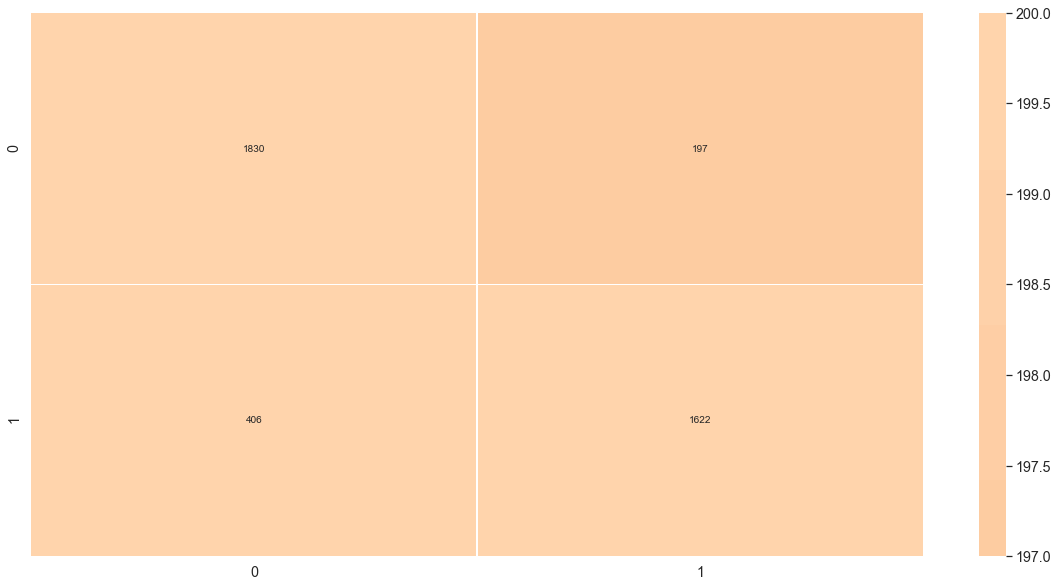

In [39]:
plt.figure(figsize=(20,10))
ax = sns.heatmap(cf, annot=True, fmt="d",linewidths=.5, center = 90, vmax = 200)

In [40]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

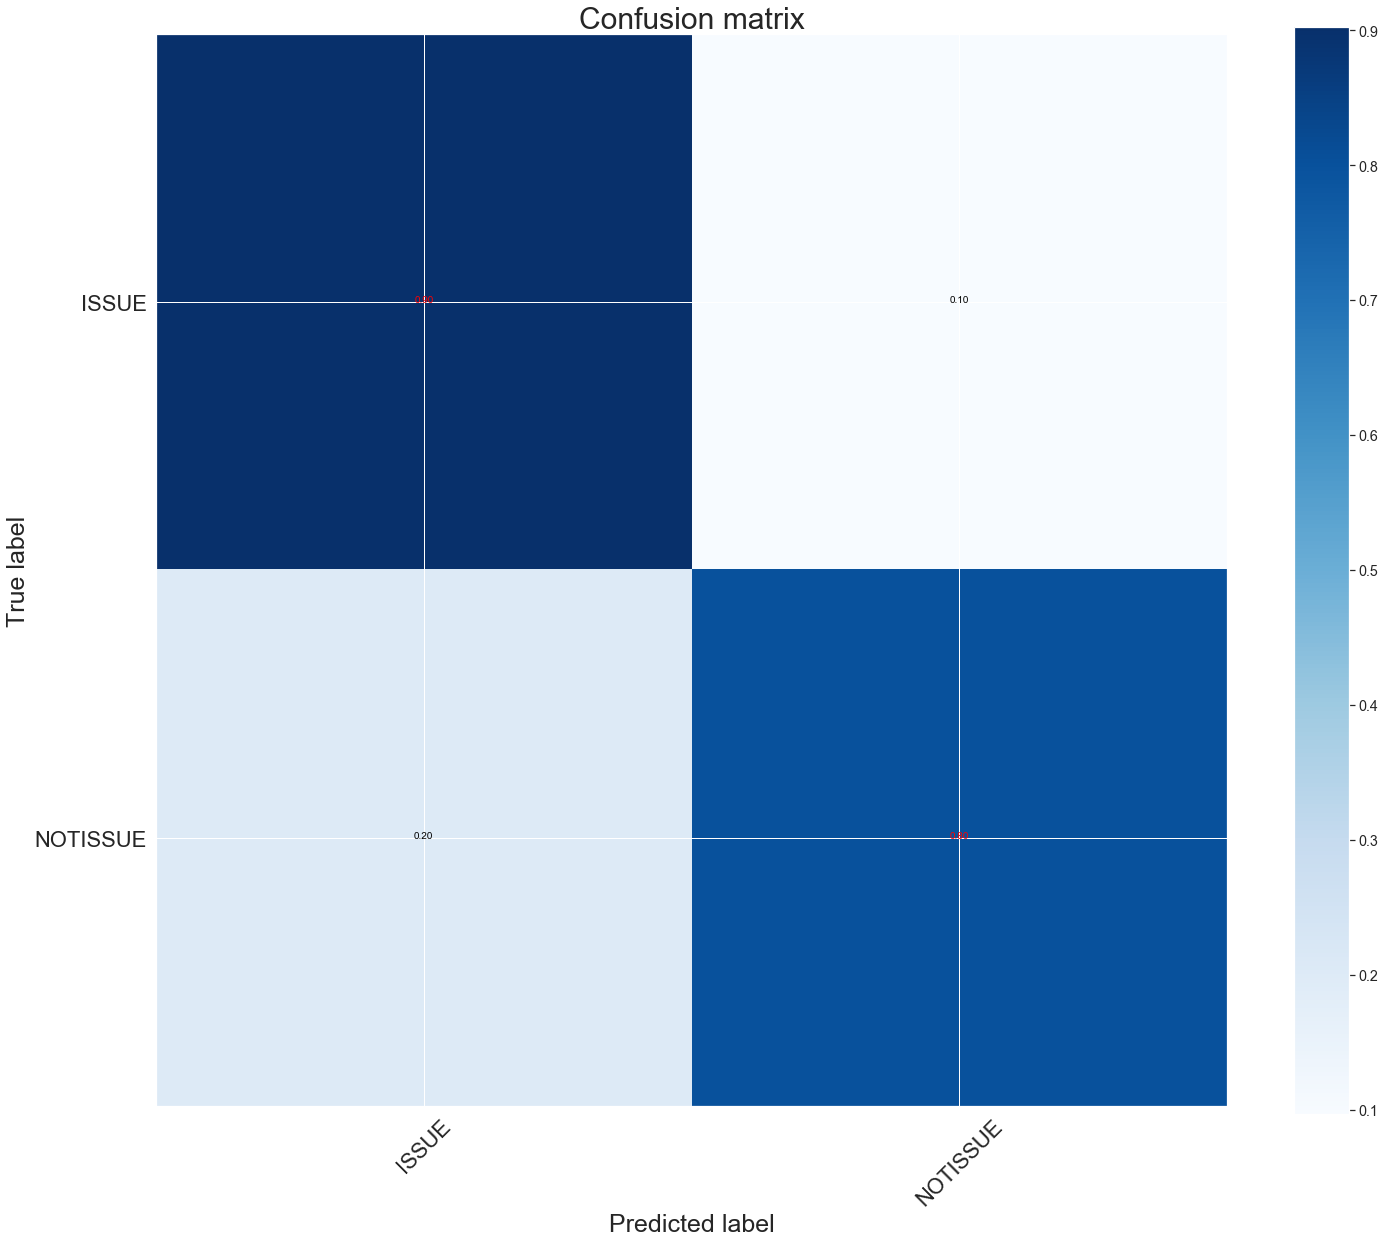

In [41]:
cnf_matrix = confusion_matrix(df.label, data_predict.label)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=['ISSUE','NOTISSUE'], title="Confusion matrix")
plt.show()

In [42]:
from sklearn.metrics import classification_report, accuracy_score

print('accuracy %s' % accuracy_score(data_predict.label, df.label))
print(classification_report(df.label, data_predict.label,target_names=['ISSUE','NOTISSUE']))

accuracy 0.8512946979038224
              precision    recall  f1-score   support

       ISSUE       0.82      0.90      0.86      2027
    NOTISSUE       0.89      0.80      0.84      2028

   micro avg       0.85      0.85      0.85      4055
   macro avg       0.86      0.85      0.85      4055
weighted avg       0.86      0.85      0.85      4055



In [43]:
def false_pos_neg(input_file,output_file,falses_file):
    diff= pd.DataFrame(columns=['true_label','pred_label', 'Text'])
    data = pd.read_csv(input_file,delimiter=',')
    data_pred = pd.read_csv(output_file,delimiter=';')
    t_labels = data.label
    p_labels = data_pred.label
    
    label=data.text.values
    t_label = t_labels.values
    p_label = p_labels.values
    for i in range(len(t_label)):
        if t_label[i]!=p_label[i]:
            diff = diff.append({'true_label':t_label[i],'pred_label':p_label[i], 'Text':label[i]},ignore_index=True)
    diff.to_csv(falses_file,sep=';')
    return diff

In [44]:
falses_file='Data/false_pred_glove300_with_text_preprocessing_version2.csv'
diff=false_pos_neg(input_file,output_file,falses_file)
print(diff)

    true_label pred_label                                               Text
0     NOTISSUE      ISSUE                                     not be happier
1     NOTISSUE      ISSUE                 be look headset long time have get
2        ISSUE   NOTISSUE  picture resolution be far comparablypriced pho...
3     NOTISSUE      ISSUE                                     prompt service
4     NOTISSUE      ISSUE                                     please headset
5     NOTISSUE      ISSUE                             do not make mistake do
6     NOTISSUE      ISSUE  sanyo have survive dozen drop blackton ill effect
7     NOTISSUE      ISSUE               find cell phone right away enter car
8        ISSUE   NOTISSUE                                        low quality
9     NOTISSUE      ISSUE  do not find it bad again unit come one arpad o...
10    NOTISSUE      ISSUE  have get defect not risk buy again build quali...
11    NOTISSUE      ISSUE                         be nothing bad say headset